# Classification of the MNIST dataset using PyTorch

The MNIST dataset consists of labelled images of hand-written numbers. In this notebook I train first a deep neural network (DNN), then a convolutional neural network (CNN), to classify these images.

## Initialise Python

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Import and prepare data

First we define a transform that tensorises and normalises the dataset.
See documentation:
- [torchvision.transforms.ToTensor](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor)
- [torchvision.transforms.Normalize](https://docs.pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # torchvision.transforms.ToTensor: Convert a PIL Image or ndarray to tensor and scale the values accordingly.
    transforms.Normalize((0.5,), (0.5,))
    # Normalize a tensor image with mean and standard deviation.
    # Here we have grayscale images (1 channel as opposed to 3 in RGB) hence we just need one value, which must be entered as a tuple.
])

Then we load the training dataset and the validation dataset directly from `torchvision`. The datasets are divided into batches of 64 images each.

In [32]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = [i for i in range(10)]

Finally we can display a batch of images from the dataset to get a feel of what the data looks like.

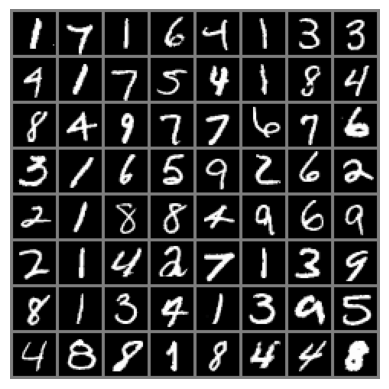

Labels:
1 7 1 6 4 1 3 3
4 1 7 5 4 1 8 4
8 4 9 7 7 6 7 6
3 1 6 5 9 2 6 2
2 1 8 8 4 9 6 9
2 1 4 2 7 1 3 9
8 1 3 4 1 3 9 5
4 8 8 1 8 4 4 8


In [33]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:")
for i in range(8):
    print(' '.join(f'{classes[labels[j]]}' for j in range(i*8, (i+1)*8)))

## Classification with a Deep Neural Network

### Define model

In [49]:
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()

        # Hidden layers
        neurons1 = 100
        neurons2 = 100
        self.hidden1 = nn.Linear(28*28, neurons1)
        self.hidden2 = nn.Linear(neurons1, neurons2)
        self.hidden3 = nn.Linear(neurons2, 10)

    def forward(self, x):
        x = x.view(-1,784) 
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        x = F.softmax(x, dim=0)

        return x

### Train the model with the Adam optimiser, using the cross-entropy loss as the objective function

In [50]:
model_DNN = SimpleDNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_DNN.parameters(), lr=1e-3)

def train_DNN(model, criterion, optimizer, train_loader, epochs = 5):
    for epoch in range(epochs):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            # print statistics
            running_loss += loss.item()

            if i % 300 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
            # if i % 2000 == 1999:    # print every 2000 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #     running_loss = 0.0
    print("Training complete")

train_DNN(model_DNN, criterion, optimizer, train_loader)

Epoch 1/5, Batch 0/938, Loss: 2.3027
Epoch 1/5, Batch 300/938, Loss: 2.1702


KeyboardInterrupt: 

### Show some results

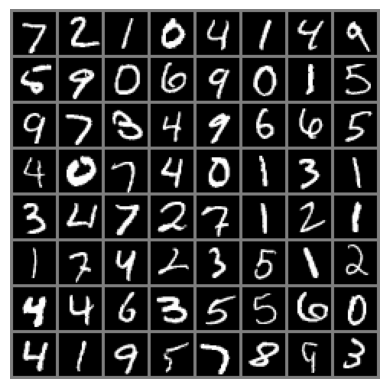

GroundTruth: 	 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3
Predicted: 	 7 2 1 0 4 1 4 9 6 9 0 8 9 0 1 5 9 7 6 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7 1 2 1 1 7 4 2 3 5 3 2 4 4 6 3 5 5 6 8 4 1 9 5 7 8 9 3


In [25]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \t', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

outputs = model_DNN(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: \t', ' '.join(f'{classes[predicted[j]]}' for j in range(batch_size)))

### Evaluate model performance

In [8]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_DNN(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 88 %


In [13]:
# count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_DNN(images)
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_pred.append(prediction)
            y_true.append(label)


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 94.9 %
Accuracy for class: 1 is 97.4 %
Accuracy for class: 2 is 87.2 %
Accuracy for class: 3 is 88.2 %
Accuracy for class: 4 is 92.2 %
Accuracy for class: 5 is 70.2 %
Accuracy for class: 6 is 94.9 %
Accuracy for class: 7 is 87.4 %
Accuracy for class: 8 is 82.0 %
Accuracy for class: 9 is 84.9 %


Display the confusion matrix

<Axes: >

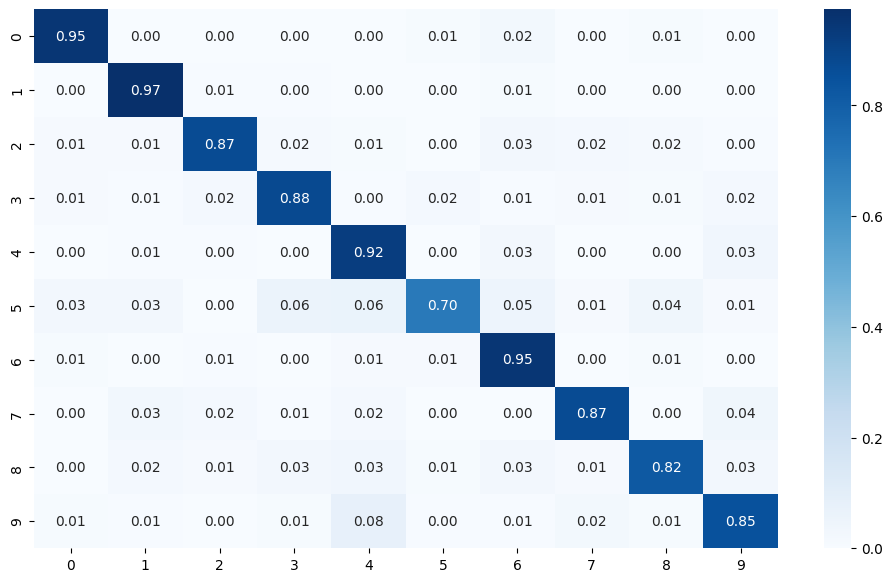

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt = ".2f", cmap='Blues')

## Classification with a Convolutional Neural Network

### Define model

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # calls the parent class initialization, which sets up PyTorch's parameter tracking and other essential functionality

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # creates and stores a convolutional layer as an attribute of this model instance
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # Applies a 2D max pooling over an input signal composed of several input planes.
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Define how data flows through the network
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)  # Flatten: "-1" indicates that this dimension (nr of rows) should be inferred given the nr of columns (64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Train

In [23]:
model_CNN = SimpleCNN() # creates an object (an instance of the SimpleCNN class), ! not a function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

In [24]:
def train_CNN(model, train_loader, criterion, optimizer, epochs=2):
    model.train()  # Set model to training mode, see https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            inputs, labels = data

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Clear old gradients
            loss.backward()         # Compute gradients
            optimizer.step()        # Update weights
            
            running_loss += loss.item()
            
            # Print progress
            if i % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}\n')

train_CNN(model_CNN, train_loader, criterion, optimizer, epochs=2)

Epoch 1/2, Batch 0/938, Loss: 2.3080
Epoch 1/2, Batch 100/938, Loss: 0.1987
Epoch 1/2, Batch 200/938, Loss: 0.1319
Epoch 1/2, Batch 300/938, Loss: 0.2192
Epoch 1/2, Batch 400/938, Loss: 0.1467
Epoch 1/2, Batch 500/938, Loss: 0.2069
Epoch 1/2, Batch 600/938, Loss: 0.0141
Epoch 1/2, Batch 700/938, Loss: 0.2136
Epoch 1/2, Batch 800/938, Loss: 0.0484
Epoch 1/2, Batch 900/938, Loss: 0.1904
Epoch 1 complete. Average Loss: 0.1847

Epoch 2/2, Batch 0/938, Loss: 0.1219
Epoch 2/2, Batch 100/938, Loss: 0.1506
Epoch 2/2, Batch 200/938, Loss: 0.0277
Epoch 2/2, Batch 300/938, Loss: 0.1076
Epoch 2/2, Batch 400/938, Loss: 0.0280
Epoch 2/2, Batch 500/938, Loss: 0.0124
Epoch 2/2, Batch 600/938, Loss: 0.0242
Epoch 2/2, Batch 700/938, Loss: 0.0279
Epoch 2/2, Batch 800/938, Loss: 0.0171
Epoch 2/2, Batch 900/938, Loss: 0.0762
Epoch 2 complete. Average Loss: 0.0584



### Visualise some results

Predictions saved to results/mnist_predictions.png


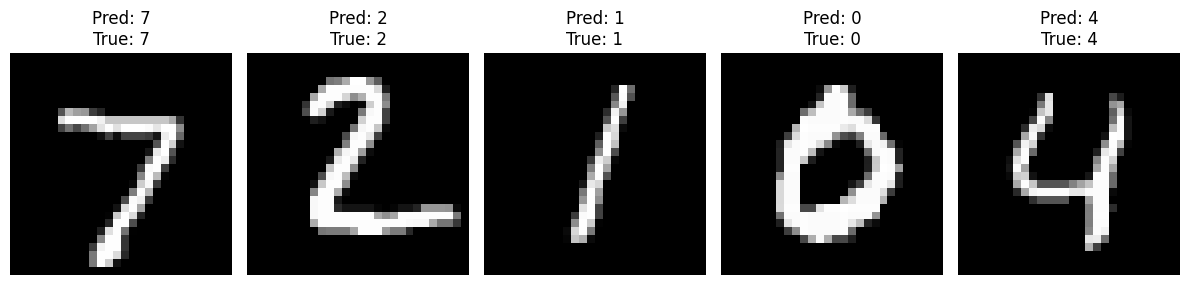

In [26]:
model_CNN.eval()  # Set to evaluation mode, see https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval

with torch.no_grad():
# Context-manager that disables gradient calculation.
# Useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.

    # Get one batch
    data, targets = next(iter(test_loader))
    outputs = model_CNN(data)
    _, predicted = torch.max(outputs, 1)
    
    # Visualize a few predictions
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        axes[i].imshow(data[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {predicted[i].item()}\nTrue: {targets[i].item()}')
        axes[i].axis('off')
    plt.tight_layout()
    print("Predictions saved to results/mnist_predictions.png")

### Evaluate model performance

In [28]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_CNN(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


In [30]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_CNN(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_pred.append(prediction)
            y_true.append(label)


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 99.6 %
Accuracy for class: 1 is 99.4 %
Accuracy for class: 2 is 98.7 %
Accuracy for class: 3 is 98.5 %
Accuracy for class: 4 is 99.4 %
Accuracy for class: 5 is 99.3 %
Accuracy for class: 6 is 98.6 %
Accuracy for class: 7 is 99.0 %
Accuracy for class: 8 is 99.2 %
Accuracy for class: 9 is 97.7 %


<Axes: >

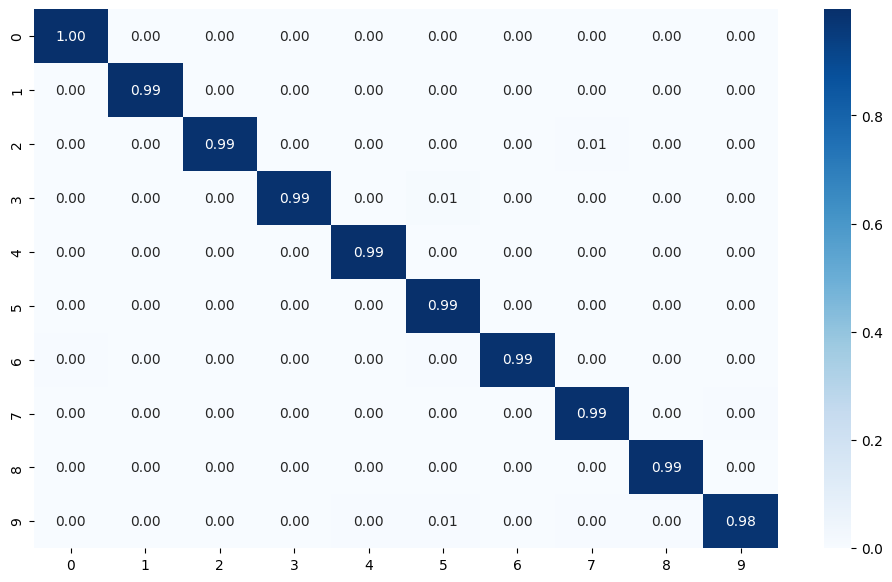

In [31]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt = ".2f", cmap='Blues')